# Семинар 3. Решение простых задач. SARSA. Q-обучение

Рассмотрим задачи с дискретными действиями и состояниями. Мы рассмотрим алгоритмы управления **on-policy** и **off-policy**.

## Содержание:

1. [Вспомним Gymnasium](#gym)
2. [SARSA](#sarsa)
3. [Q-обучение](#qlearn)


In [ ]:
# @title Установка зависимостей

try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [ ]:
# @title Импортирование зависимостей

import time
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import torch
import torch.nn as nn
from collections import deque

def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def show_progress(rewards_batch, log):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(log, label='Mean rewards')
    plt.legend(loc=4)
    plt.show()

# 1. Вспомним Gymnasium <a name = 'gym'></a>

Будем рассматривать среду [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Обратите внимание на среды [Toy text](https://gymnasium.farama.org/environments/toy_text/)

In [ ]:
def video_episode(env_name, policy=None):
    # создаем среду с ограничением на число шагов в среде
    env = gym.make(env_name, render_mode="rgb_array", max_episode_steps=250)
    # добавляем визуализацию
    env = RecordVideo(env, f"./video", name_prefix=str(int(time.time())))

    # проводим инициализацию и запоминаем начальное состояние
    s, _ = env.reset()
    done = False

    while not done:
        # выполняем действие, получаем s, r, term, trunc, info
        if policy:
            s, r, terminated, truncated, _ = env.step(policy(s))
        else:
            s, r, terminated, truncated, _ = env.step(env.action_space.sample())
        done = terminated or truncated

    env.close()
    show_video()

In [ ]:
video_episode("CliffWalking-v1")

Как определить пространство действий и пространство состояний среды Gymnasium?

In [ ]:
env = gym.make("Taxi-v3", render_mode="rgb_array", max_episode_steps=250)
s, info = env.reset()

Посмотрим, на что способна случайная стратегия.

In [ ]:
env = gym.make("FrozenLake-v1", render_mode='rgb_array')
env.reset()
log = []
rewards_batch = []
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()
    r, episode_reward = 0, 0
    done = False
    while not done:
        a = env.action_space.sample()
        # выполняем действие в среде
        next_s, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:
        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}")

## Задание

Создайте таблицу из нулей, используя информацию из среды о количестве состояний и действий.

In [ ]:
def initialize_q_table(observation_space_n, action_space_n):
    # Q = [state][action]
    ####### Здесь ваш код ########

    ##############################
    return Q

In [ ]:
# Проверка таблицы - размеры, тип.
n_states, n_actions = 3, 5
Q = initialize_q_table(n_states, n_actions)
assert isinstance(Q, np.ndarray) and len(Q.shape) == 2, 'результат должен быть 2D нумпаевским вектором'
assert Q.shape[0] == n_states and Q.shape[1] == n_actions, 'проверь размерности: [N состояний][M действий]'
assert not Q.any(), 'инициализация должна быть нулями'

## Задание

Напишите код для epsilon-жадного выбора действия:


In [ ]:
def select_action_eps_greedy(Q, state, epsilon):
    # выбираем действие, используя eps-greedy исследование среды:
    # 1) с вероятностью epsilon выбираем случайное действие,
    # 2) иначе выбираем действие жадно
    # action =
    ####### Здесь ваш код ########

    ##############################
    return action

# 2. SARSA <a name = 'sarsa'></a>

Sutton, R. S., Barto, A. G. (2018 ). Reinforcement Learning: An Introduction. The MIT Press. p. 130.

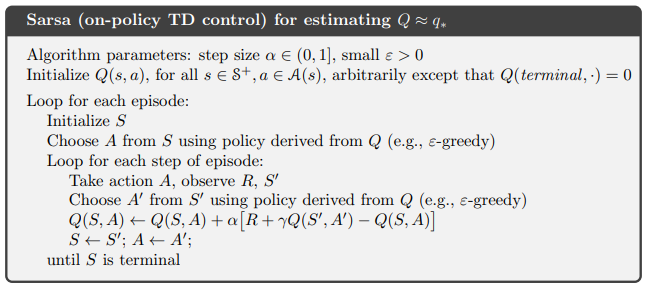

## Задание

Допишите SARSA обновление Q функции.

In [ ]:
def update_Q_SARSA(Q, s, a, r, next_s, next_a, alpha, gamma):
    # посчитайте TD ошибку
    # td_error =
    ####### Здесь ваш код ########

    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error

Обучение и управление по SARSA:

In [ ]:
env = gym.make("CliffWalking-v1", render_mode='rgb_array')
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    done = False
    a = select_action_eps_greedy(Q, s, epsilon)

    while not done:
        # выполняем действие в среде
        next_s, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated

        next_a = select_action_eps_greedy(Q, next_s, epsilon)
        update_Q_SARSA(Q, s, a, r, next_s, next_a, alpha, gamma)

        s = next_s
        a = next_a
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:

        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
        epsilon *= epsilon_decay

In [ ]:
video_episode("CliffWalking-v1", lambda x: select_action_eps_greedy(Q, x, 0))

# 3. Q-обучение <a name = 'qlearn'></a>

Sutton, R. S., Barto, A. G. (2018 ). Reinforcement Learning: An Introduction. The MIT Press. p. 131.

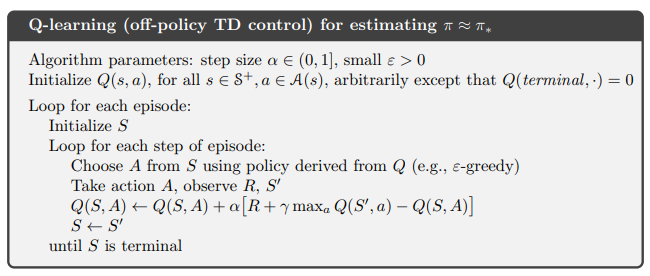

## Задание

Напишите код для формулы Q-обновления.

In [ ]:
def update_Q(Q, s, a, r, next_s, alpha, gamma):
    # вычислите V(next_s) - estimate of optimal future value
    # V_ns =
    ####### Здесь ваш код ########

    ##############################

    # посчитайте TD ошибку
    # td_error =
    ####### Здесь ваш код ########

    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error

Ниже представлен код для Q-обучения. В чем отличие от SARSA итераций?

In [ ]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    done = False

    while not done:

        a = select_action_eps_greedy(Q, s, epsilon)

        next_s, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        update_Q(Q, s, a, r, next_s, alpha, gamma,)

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:
        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
        epsilon *= epsilon_decay

In [ ]:
video_episode("CliffWalking-v1", lambda x: select_action_eps_greedy(Q, x, 0))

## Задание

Попробуйте разные среды из набора Toy Text. Изучите, как меняются результаты для SARSA и Q обучения.